In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets as dset
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, sampler
# from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd drive/My\ Drive/DeepAdDetection/
!pwd


/content/drive/My Drive/DeepAdDetection
/content/drive/My Drive/DeepAdDetection


In [4]:
np.random.seed(0)
torch.manual_seed(0)

In [0]:
%matplotlib inline
sns.set_style('darkgrid')

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

!pwd
root_dir = "."
print("The data lies here =>", root_dir)

We're using => cuda
/content/drive/My Drive/DeepAdDetection
The data lies here => .


In [7]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

train = datasets.ImageFolder(root ="./data-new",transform = image_transforms["train"])
test = datasets.ImageFolder(root ="./test", transform = image_transforms["test"])


train_indices = list(range(len(train)))
np.random.shuffle(train_indices)
train_indices = train_indices[:5000] # remove later
val_split_index = int(np.floor(0.2 * 5000)) # change to len train later
train_idx, val_idx = train_indices[val_split_index:], train_indices[:val_split_index]
print(train_idx, val_idx)
print(len(train_idx), len(val_idx))
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(dataset=train, shuffle=False, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset=train, shuffle=False, batch_size=1, sampler=val_sampler)
test_loader = DataLoader(dataset=test, shuffle=False, batch_size=1)

[12225, 2669, 16642, 3374, 16756, 19362, 11339, 5127, 11101, 12340, 1921, 10934, 13389, 2906, 11826, 1751, 12636, 6869, 5589, 15011, 8787, 14383, 13212, 18835, 11681, 10287, 12831, 3176, 13178, 6086, 19772, 8357, 17523, 9107, 664, 1569, 13438, 10962, 7331, 8690, 2156, 4604, 12021, 19628, 4683, 14996, 5449, 5648, 10118, 4359, 12034, 5008, 1557, 10865, 10079, 2011, 1195, 9018, 13548, 20371, 8035, 15116, 3064, 2124, 15948, 8585, 5594, 9075, 18902, 17257, 7182, 772, 15655, 19288, 4152, 6768, 717, 4008, 3144, 19214, 5212, 7254, 9236, 2450, 11274, 7340, 3662, 15029, 12789, 2108, 12666, 12343, 220, 10427, 3268, 18564, 18640, 768, 1628, 12410, 15601, 8941, 18495, 8037, 15189, 17995, 12438, 6183, 12939, 13297, 7735, 4962, 17862, 14199, 18006, 6680, 19285, 1295, 9939, 18138, 5777, 7796, 19105, 4630, 10279, 17141, 13162, 19732, 4800, 4808, 19009, 18378, 15105, 14563, 9707, 371, 4847, 183, 17750, 3998, 11135, 13124, 11514, 2763, 18943, 1165, 1752, 14896, 12829, 14242, 8950, 17155, 8308, 19840, 735

In [8]:
train.class_to_idx

{'ad': 0, 'not-ad': 1}

In [0]:
idx2class = {v: k for k, v in train.class_to_idx.items()}

In [0]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    print(count_dict)
    return count_dict


def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

In [0]:
class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        
        x = self.block2(x)
    
        x = self.block3(x)
        x = self.maxpool(x)
        
        x = self.lastcnn(x)
        
        return x
    
    
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        
        return seq_block

In [12]:
model = classifier()
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)

classifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [0]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [0]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

In [15]:
print("Begin training.")

for e in tqdm(range(1, 6)):
    
    # TRAINING
    
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for i, (X_train_batch, y_train_batch) in enumerate(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch).squeeze()
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        print(i, len(train_loader), train_epoch_loss, train_epoch_acc)
        
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
                                    
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


0 500 0.6566027402877808 62.0
1 500 38.2814120054245 112.0
2 500 247.81513392925262 162.0
3 500 690.4060763120651 212.0
4 500 856.379434466362 287.0
5 500 1041.0174959897995 337.0
6 500 1270.7606600522995 399.0
7 500 1683.5256441831589 424.0
8 500 2061.2033480405807 449.0
9 500 2178.1297549009323 511.0
10 500 2325.933847308159 549.0
11 500 2490.646493792534 611.0
12 500 2675.268579363823 661.0
13 500 2690.7009838819504 736.0
14 500 2748.241732478142 798.0
15 500 2938.668246150017 836.0
16 500 3210.856783747673 848.0
17 500 3285.5443600416183 910.0
18 500 3391.2558315992355 972.0
19 500 3519.0096920728683 1010.0
20 500 3610.6052426099777 1072.0
21 500 3774.7485378980637 1122.0
22 500 3896.241488337517 1172.0
23 500 4035.2421597242355 1247.0
24 500 4209.445635676384 1272.0
25 500 4290.344149470329 1310.0
26 500 4453.317553400993 1360.0
27 500 4564.57899749279 1398.0
28 500 4570.973539233208 1473.0
29 500 4570.973541259766 1573.0
30 500 4622.404495239258 1648.0
31 500 4675.8640213012695 1

   epochs variable   value
0       0    train  54.198
1       1    train  57.896
2       2    train  59.200
3       3    train  59.724
4       4    train  60.474
5       0      val  25.000
6       1      val  50.000
7       2      val  50.000
8       3      val  62.000
9       4      val  62.000
   epochs variable      value
0       0    train  34.318949
1       1    train   0.711940
2       2    train   0.679054
3       3    train   0.676548
4       4    train   0.681304
5       0      val   1.217376
6       1      val   0.730088
7       2      val   0.672668
8       3      val   0.647641
9       4      val   0.701900


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

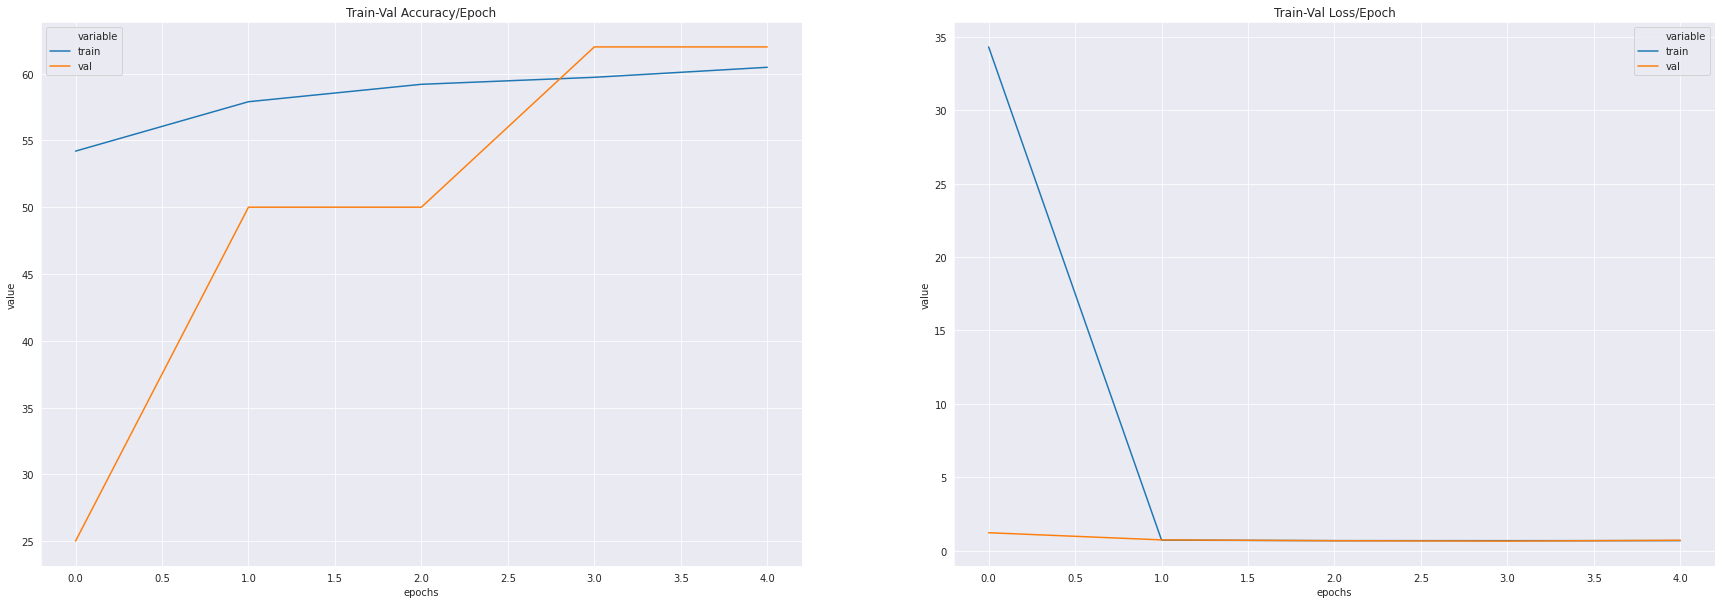

In [16]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

print(train_val_acc_df)
print(train_val_loss_df)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [17]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

y_pred_list = [i[0][0][0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      4657
           1       0.00      0.00      0.00         0

    accuracy                           0.00      4657
   macro avg       0.50      0.00      0.00      4657
weighted avg       1.00      0.00      0.00      4657

[[   6 4651]
 [   0    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


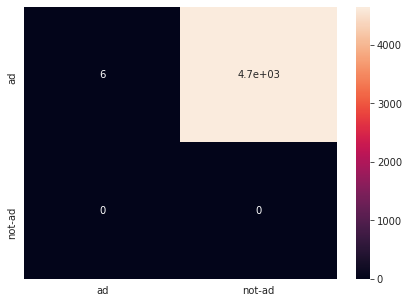

In [20]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)

fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)